In [1]:
import os
import cv2
import csv
import json
import math
import random
import decord
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageSequence
from io import BytesIO
from IPython.display import Video
from IPython.display import display, Image as IPyImage
import torchvision.transforms as T

import sys
from media_pipe.mp_utils  import LMKExtractor
from media_pipe.draw_util import FaceMeshVisualizer
from media_pipe.pose_util import project_points_with_trans, matrix_to_euler_and_translation, euler_and_translation_to_matrix


ROOT = 'root_path'

def show_img(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img)
    plt.show()
    
def read_video(video_path):
    vr = decord.VideoReader(video_path)
    frames = vr.get_batch(list(range(len(vr))))
    return frames
    
def display_gif(image_array, duration=100):
    # 将NumPy数组转换为PIL图像列表
    images = [Image.fromarray(frame) for frame in image_array]

    # 将图像保存为GIF并将其读入内存缓冲区
    buffer = BytesIO()
    images[0].save(buffer, format='GIF', save_all=True, append_images=images[1:], duration=duration, loop=0)

    # 在Jupyter Notebook中显示GIF
    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

In [2]:
lmk_extractor = LMKExtractor()
vis = FaceMeshVisualizer(forehead_edge=False)

W20240527 09:29:14.175659 2415689 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


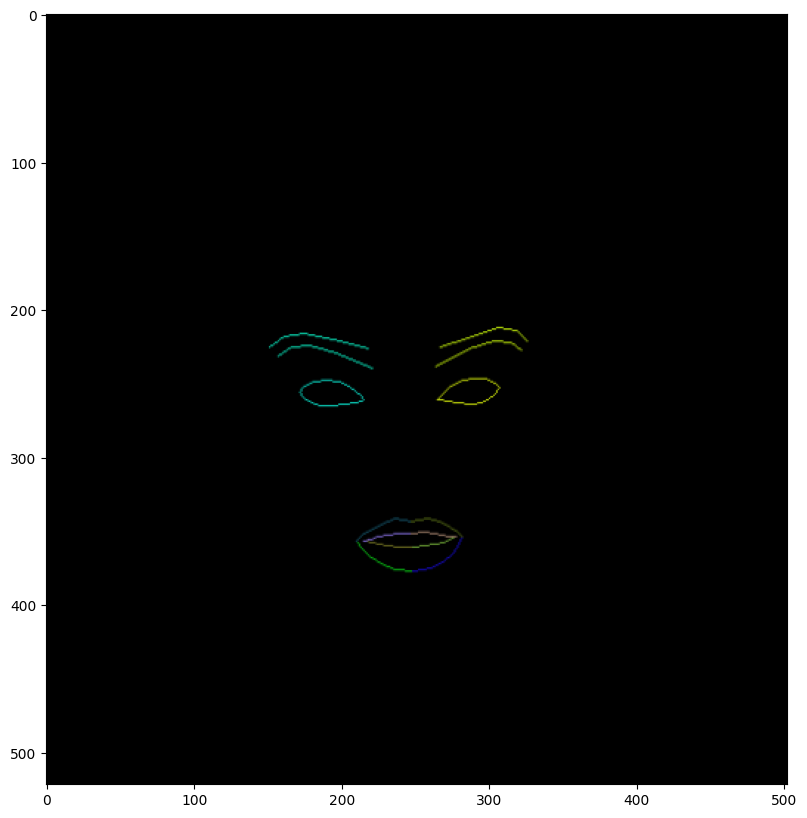

In [34]:
# 测试能否被检测到landmark

ref_image_path = f'{ROOT}/image_path'
ref_image_pil = Image.open(ref_image_path).convert("RGB")
ref_image_np = cv2.cvtColor(np.array(ref_image_pil), cv2.COLOR_RGB2BGR)
# show_img(ref_image_pil)

face_result = lmk_extractor(ref_image_np)
assert face_result is not None, "Can not detect a face in the reference image."
face_result['width'] = ref_image_np.shape[1]
face_result['height'] = ref_image_np.shape[0]

save_path = ref_image_path.replace('.png', '_mppose.npy')
np.save(save_path, face_result)

lmks = face_result['lmks'].astype(np.float32)
ref_pose = vis.draw_landmarks((ref_image_np.shape[1], ref_image_np.shape[0]), lmks, normed=True)
show_img(ref_pose)

## 模板提取

In [9]:
from tqdm import tqdm

video_path = f'{ROOT}/video_path'
frames = imageio.get_reader(video_path)
face_results = []
motions = []
for frame in tqdm(frames):
    frame_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
    
    face_result = lmk_extractor(frame_bgr)
    assert face_result is not None, "Can not detect a face in the reference image."
    face_result['width'] = frame_bgr.shape[1]
    face_result['height'] = frame_bgr.shape[0]
    
    face_results.append(face_result)
    lmks = face_result['lmks'].astype(np.float32)
    motion = vis.draw_landmarks((frame_bgr.shape[1], frame_bgr.shape[0]), lmks, normed=True)
    motions.append(motion)

print(len(motions))

save_path = video_path.replace('.mp4', '_mppose.gif')
imageio.mimsave(save_path, motions, 'GIF', duration=0.2, loop=0)
print(save_path, 'done')

save_path = video_path.replace('.mp4', '_mppose.npy')
np.save(save_path, face_results)
print(save_path, 'done')

  0%|                       | 1420/9223372036854775807 [00:28<50561808764202:56:32, 50.67it/s]


1420
/apdcephfs_cq8/share_1367250/mayuema/emoji_source_video/temple45.mov done
/apdcephfs_cq8/share_1367250/mayuema/emoji_source_video/temple45.mov done


## Align